<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/draft_sequences/convergence_rate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S2"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.3.2: Optimizing a Quadratic of Many Variables with Propose-Accept-Reject and Perturb-Measure-Step

In the previous sequences we built up our intuitions around the Propose-Accept-Reject algorithm in lower dimensions. Now we're going to try to develop our intuitions around how the number of dimensions, or scale, of the problem affects the rate at which Propose-Accept-Reject can get close to an optimal solution. Systematic comparisons of learning algorithms is notorously fraught, different meta-parameter setting (e.g. step size) can make a huge difference, and in general good meta-parameters for one alogorithm-problem combination, will be very different from the good meta-parameters for a different algorithm-problem combination. All the details kind of matter. That said we can still develop some useful intuitions about scale, by studying a very simple system.

We will use the simple quadratic function

$$f(\mathbf{x}) = \sum_{i=1}^{N}x_i^2 $$

and see how the rate of convergence to a good solution changes as we increase the number of dimensions. We will run our algorithms until either 1000 iterations have been completed, or the value of $f(\mathbf{x})$ is less 0.1. For ease of comparison we will initialize $\mathbf{x}$ randomly, such that $\| \mathbf{x} \| = 5$.

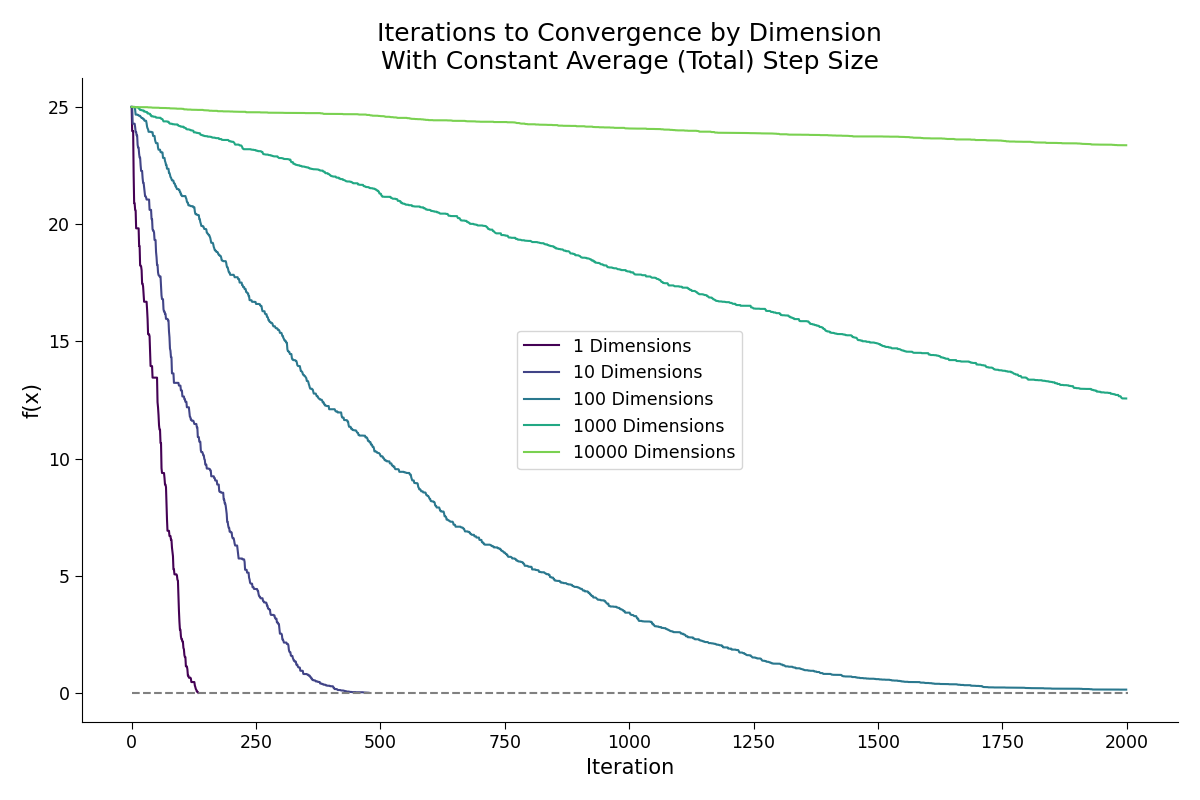

In [2]:
# @markdown **Run this cell** to see how iterations to convergence changes as the number of dimensions increases
def simple_quadratic(x):
  return np.dot(x,x)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

def fixed_scale_propose(x, step_size=0.1, rng=np.random.default_rng()):
  proposed_x = x + rng.standard_normal(size=x.shape) * step_size
  return proposed_x

# propose accept reject loop
step_size = 0.1
max_proposals = 2000
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size**2:
    proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color=colors[ii])
ax.hlines(step_size**2, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\nWith Constant Average (Total) Step Size')
ax.legend()

plt.show()

The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is

$$
\mathbf{x}_{\text{proposed}} = \mathbf{x}_{\text{current}} + \mathbf{\xi}
$$

with $\mathbf{\xi} \sim \sigma \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. The average size of a perturbation, i.e., its Euclidean length $\|\mathbf{\xi} \|$, is given by

$$ \begin{align}
\mathbb{E}[\|\mathbf{\xi} \|] &= \mathbb{E}\left[\sqrt{\sum_{i=1}^N \xi_i^2}\right] = \sigma \mathbb{E}[\chi_N] = \sigma \sqrt{2} \frac{\Gamma\left(\frac{N+1}{2}\right)}{\Gamma\left(\frac{N}{2}\right)} \\
&\approx \sigma \sqrt{N} \ \text{for large } N.
\end{align}$$

Here $\chi_N$ denotes a chi distribution with $N$ degrees of freedom, representing the distribution of the norm of a vector of $N$ independent standard normal random variables. ($\Gamma$ denotes the gamma function which is a generalization of the factorial function on integers to real and complex values.) For high dimensions, i.e., large $N$, the approximation $\sigma \sqrt{N}$ becomes increasingly accurate due to the central limit theorem.

Thus to have a consistent average proposal step length, $s$, we need to have $\sigma = \frac{s}{\sqrt{N}}$. If instead have a constant $\sigma$ as dimension increase, the average sizes of the steps will increase as the number of the dimensions increases. This is problematic as illustrated below.

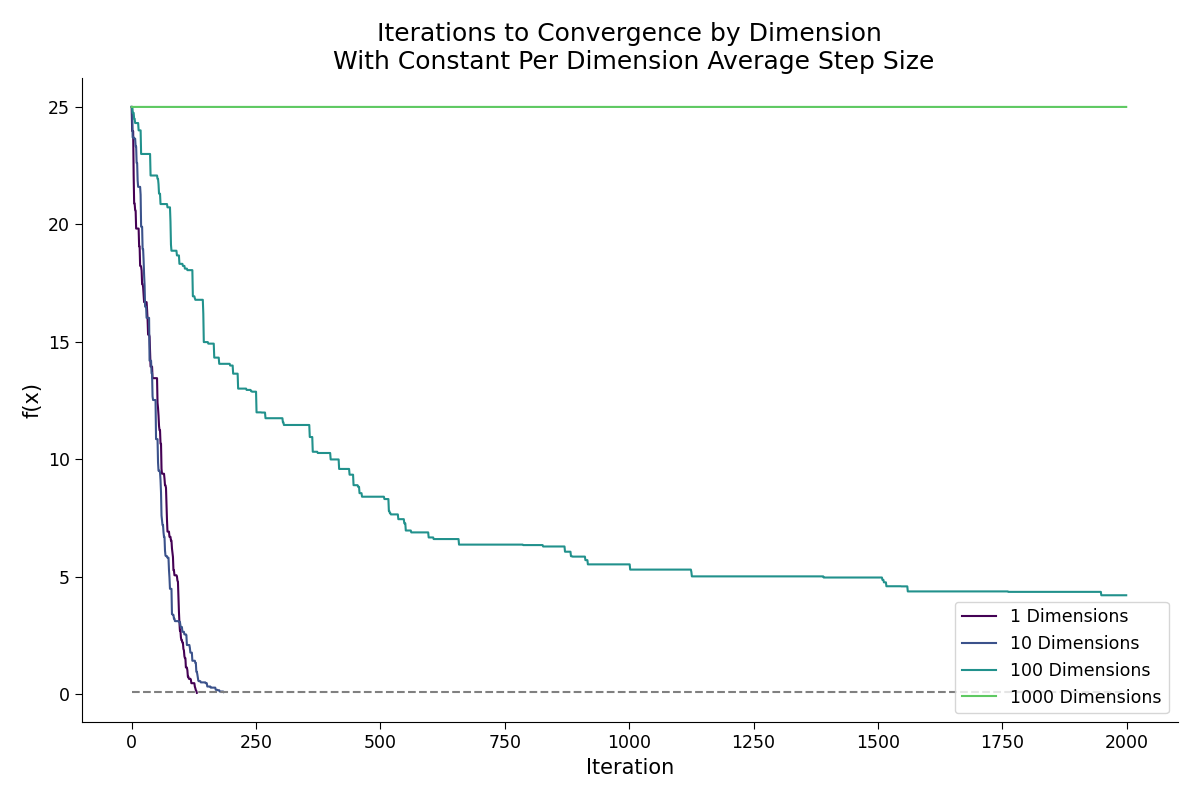

In [3]:
# @markdown **Run this cell** to see how having step size increase with dimension is a problem.
# propose accept reject loop
step_size = 0.1
starting_distance_from_optimal = 5
par_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000] # number of dimensions
x_histories = []
z_histories = []
max_proposals = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_proposed = 0
  num_accepted = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    proposed_x = fixed_scale_propose(x, step_size=step_size, rng=par_rng)
    num_proposed += 1
    z_proposed = simple_quadratic(proposed_x)
    if z_proposed < z:
      x = proposed_x
      z = z_proposed
      num_accepted += 1
    x_history.append(x)
    z_history.append(z)
    if num_proposed > max_proposals:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plotting the data
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Iterations to Convergence by Dimension\n With Constant Per Dimension Average Step Size')
ax.legend()

plt.show()

Having step size scale up with dimension can lead to fast convergence at first (bigger step sizes means you get where you're going more quickly) but at some point large step sizes make it more difficult to zero in on the exact location of the optimal value. Larger step sizes limit percision, eventually to the point where no improvment is made.

Now that we've seen what increasing the number of dimensions does to convergence rate of propose-accept-reject, let's take a look at perturb-measure-step.

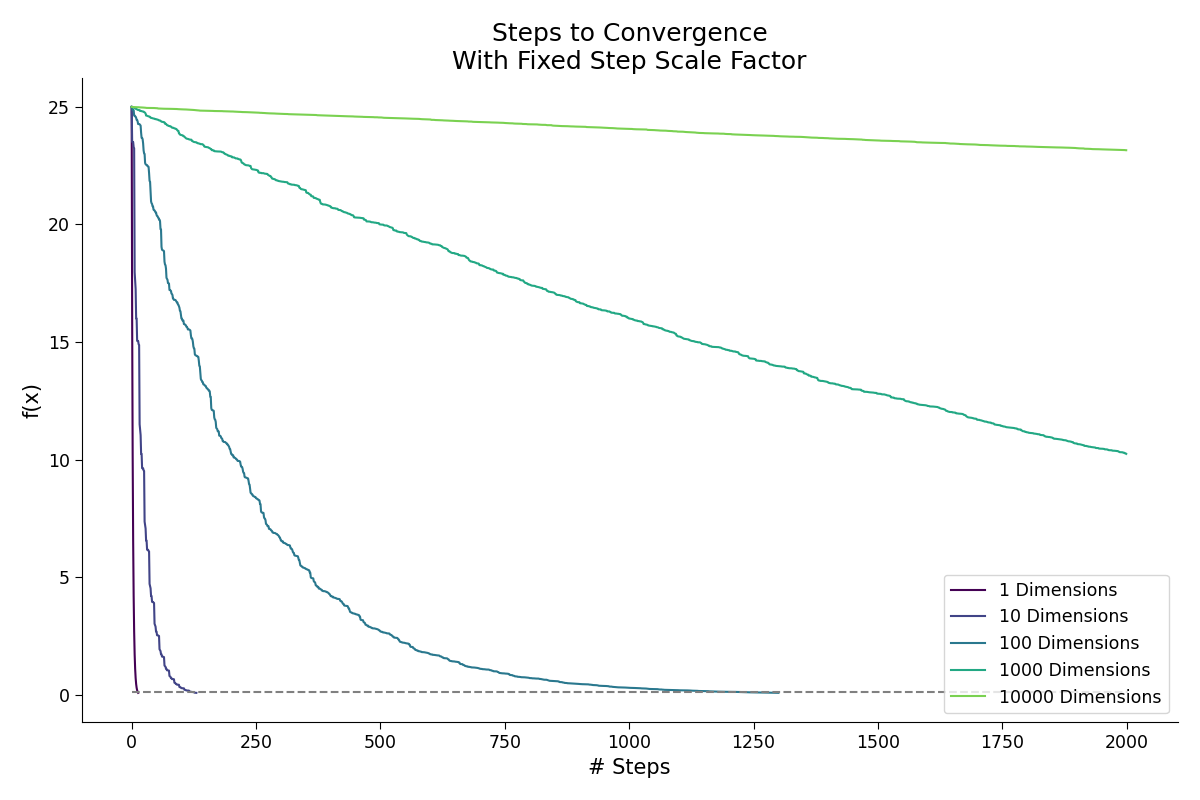

In [4]:
# @markdown **Run this cell** to look at convergence rates in different dimensions for perturb-measure-step
test_perturb = 0.00001
step_scale = 0.1
starting_distance_from_optimal = 5
pms_rng = np.random.default_rng(42)
N_Dim = [1, 10, 100, 1000, 10000] # number of dimensions
x_histories = []
z_histories = []
max_steps = 2000
for N in N_Dim:
  x_history = []
  z_history = []
  num_steps = 0
  num_function_evaluations = 0
  # initialize x
  x = par_rng.standard_normal(size=N)
  x = x / np.linalg.norm(x) * starting_distance_from_optimal
  z = simple_quadratic(x)
  num_function_evaluations += 1
  x_history.append(x)
  z_history.append(z)
  while z_history[-1] > step_size:
    for dim in range(N):
      x[dim] += test_perturb #perturb
      z_test = simple_quadratic(x) #test
      x[dim] -= test_perturb # un-perturb
      dim_grad_est = (z_test - z) / test_perturb #measure slope
      x[dim] -= step_scale * dim_grad_est #step
      num_steps += 1
      z = simple_quadratic(x)
      num_function_evaluations += 2
      x_history.append(x)
      z_history.append(z)
      if num_steps > max_steps:
        break
    if num_steps > max_steps:
      break
  x_histories.append(x_history)
  z_histories.append(z_history)

fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)+1))
# Plot each dimensions history
for ii, z_history in enumerate(z_histories):
  if len(z_history) > max_proposals:
    z_history = z_history[:max_proposals]
  ax.plot(z_history, label=f'{N_Dim[ii]} Dimensions', color= colors[ii])
ax.hlines(0.1, 0, len(z_histories[-1]), linestyles='dashed', colors='gray')
ax.set_xlabel('# Steps')
ax.set_ylabel('f(x)')
ax.set_title('Steps to Convergence\nWith Fixed Step Scale Factor')
ax.legend()

plt.show()

The number of iterations here to convergence increases with dimension, partly because, this version of perturb-measure-step basically treats each dimension in isolation, so $N$ steps are required to make improvements in all $N$ dimensions. In the case above where we have 10,000 dimensions, but only run for 2000 steps, 8000 of the elements of $\mathbf{x}$ have been improved. Scale is important for the brain. Recall that there are trillions of synapses the brains of brainy animals. Learning in the brain is going to require optimzation algorithms that are still effective in high dimensions.

# 2.1.3.3 Perturb-Meausre-Step and Propose-Accept-Reject Are Always Slow in Higher Dimensions.

As mentioned before, comparing algorithms is notoriously difficult, so much can depend upon the specifics of the problems being used for comparison, and the interplay of the meta-parameters of the optimization algorithm with the specifics of the problem. To navigate through this potential noise, we're going to use an analytical approach. Our problem setup is as follows:

We consider a function \(f(\mathbf{x})\) that is *analytic*. This has a precise mathematical meaning, but intuitively it means that the function does not exhibit excessive local variability. More formally, an analytic function can be locally expressed by a convergent power series. For our purposes, this implies smoothness and the absence of abrupt changes in behavior, which in turn allows for reliable use of linear approximations in the vicinity of any point within its domain. Specifically, the function can be approximated as:

$$
f(\mathbf{x} + \mathbf{\delta}) \approx f(\mathbf{x}) + \mathbf{\delta} \cdot \mathbf{g})
$$

where $\mathbf{g} = \nabla f(\mathbf{x}) = \left. \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \dots, \frac{\partial f}{\partial x_n} \right)\right|_{\mathbf{x}}$ is the gradient of $f$ evalutated at $\mathbf{x}$, $\mathbf{\delta}$ is a small perturbation vector in $\mathbb{R}^n$, and $\mathbf{delta} \cdot \mathbf{g}$ is the inner product of the two vectors.
Note that the perturbation $\mathbf{\delta}$ must be sufficiently small. As $\|\mathbf{\delta}\|$ increases in magnitude, higher-order terms in the Taylor expansion of $f$ at $\mathbf{x}$ become significant, and the linear approximation becomes less accurate.

Okay so now we want to think about our two algorithms, propose-accept-reject and perturb-measure-step, and ask, for any analytic function, at any point $\mathbf{x}$, with a given step size $s$, what is the average expected improvement from a single interation of the algorithm, and how does this expected improvement compare to the 'best possible' improvement of taking a step in the direction of the gradient?



## Propose-accept-reject analysis
Let's start, propose-accept-reject goes first.

1. The proposals in propose-accept-reject are generated by adding Gaussian noise to the current $\mathbf{x}$ value that is
$$
\mathbf{x}' = \mathbf{x} + \mathbf{\xi}
$$
with $\mathbf{\xi} \sim \frac{s}{\sqrt{n}} \cdot \mathcal{N}(\mathbf{0}, \mathbf{I})$. We scale each perturbation by $\frac{s}{\sqrt{n}}$ so that $\mathbb{E}\left[\| \mathbf{\xi} \|\right] = s$.If we reject a proposal the improvement is zero.
2. We assume that $s$ is small enough, that the linear approximation is good, and the expected change in the function is then simply $$ \xi \cdot \mathbf{g}$$
3. Now we haven't said what $\mathbf{g}$ is or what $f$ is, so at first glance it may seem crazy to try and compute this, but we're about to do a sneaky math trick so pay attention. We're going to do a change of coordinates. $\mathbf{\xi}$ is basically a little Guassian cloud, and the density of this cloud is isotropic, that means the same in all radial dimensions, so that means that any rigid rotation of coordinates will leave the distribution unchanged. Okay, now $\mathbf{g}$ can be re-written as the product of a unit direction vector $\frac{\mathbf{g}}{\|\mathbf{g}\|}$ and a magnitude $\|\mathbf{g}\|$. Then we can shift our coordinates so that our first dimension is perfectly aligned with the gradient, and all other $n-1$ dimensions are perfectly unaligned with the gradient. In this new coordinate system $\mathbf{g} = \|\mathbf{g}\|(1, 0, \cdots, 0)$, and then the inner product of is simply $$(\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) \|\mathbf{g}\| = \xi_1 \|\mathbf{g}\|$$
4. Then $\mathbb{E}\left[\xi_1 | \text{Proposal Accepted} \right] = s \sqrt{\frac{2}{n \pi}}$, since the proposal will only be accepted if $\xi_1 > 0$, so conditional on acceptance $\xi_1$ follows a half-normal or $\chi_1$ distribution.
5. If a proposal is accepted the expected improvement is $$s \|\mathbf{g}\| \sqrt{\frac{2}{n \pi}}$$
5. By the symetry of the normal distribution we also have that on average, half of the time proposals will be rejected and half of the time they will be accepted.
6. When a proposal is rejected the improvement is zero
7. Putting this all together the expected rate of improvement per iteration of propose-accept-reject is
$$ \frac{s\|\mathbf{g}\|}{\sqrt{2\pi n}}$$

Now if we were to just know the direction of $\mathbf{g}$ and step $s$ in that direction, the improvement would be $s\|\mathbf{g}\|$. So we see that the rate of improvement relative to the optimally oriented small step is reduced by a factor of $\frac{1}{\sqrt{2 \pi n }}$. Intuitively as the number of dimensions increases, random step directions are less and less likely to be well aligned with this optimal direction. Note that if we were to use our 'always-step' variant of propose-accept-reject, we could do a little better with
$$ \frac{s\|\mathbf{g}\|\sqrt{2}}{\sqrt{\pi n}}$$ but we would still have our expected improvement per step drop of with $\frac{1}{\sqrt{n}}$

## Perturb-Measure-Step Analysis

Okay now the same for perturb-measure-step. In pertrub-measure-step we iterate through the dimensions generating a test point according to
$$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\mathbf{e}^i
$$
Where $\mathbf{e}^i$ is an ortho-normal basis vector, for the $i^{th}$ dimension. By measuring the change caused by this perturbation we can get a good estimate of the $g_i$, the component of the gradient in the $i^{th}$ dimension. Based on this the estimate of $g_i$ we then steps $s \cdot g_i$ in the $i^{th}$ dimension. Now because we don't know anything about the particular structure of $\mathbf{g}$ and the function $f$, it hard to say much about what kind of improvement we will get out of any one step in any one dimension, but we do know that after iterating through all $n$ dimensions we will have taken a step roughly in the direction of the gradient, and that the length of this combination of $n$-steps is $\sqrt{\sum_{i=1}^{n} s^2 g_i^2} = s \|\mathbf{g}\| $. Now the rate of improvement in the direction of the gradient is $\|\mathbf{g}\|$, so the expected improvement over $n$ steps will be roughly $ s\|\mathbf{g}\|^2$. Then on average, each step will contribute an improvement of

$$\frac{s\|\mathbf{g}\|^2}{n}$$

The rate of improvement for perturb-measure-step drops off with $\frac{1}{n}$, even faster than that of propose-accept-reject. This analysis is a little loose, since $\mathbf{g}$ will change slightly as steps are taken, but it could be tightened up by analyzing a more tractable "stochastic" variant of pertrub-measure-step, in which instead of iterating through the directions systematically, a random direction is chosen for perturbation. This random direction could be chosen from the $n$ orthonormal basis directions, in which case the analysis is much as above, or the direction could be choose uniformly over all possible directions, i.e. using $$
\mathbf{x}' = \mathbf{x} + s_{\text{test}}\frac{\xi}{\|\xi\|}
$$
With $\mathbf{\xi} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. Then we can do our same coordinate shifting trick to get the expected rate of improvement in the direction of $\xi$ as
$$ \frac{\xi}{\| \xi \|} \cdot \mathbf{g} = \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|} (\xi_1 \cdot 1 + \xi_2 \cdot 0 + \dots + \xi_n \cdot 0) = \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$$.

The algorithm will then take a step of length $s \xi_1 \frac{\| \mathbf{g}\|}{\| \mathbf{\xi}\|}$ in the direction of $\xi$ and this will result in an improvement of $$ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}$$.

Now $\xi_1^2$ \| follows a $\chi^2_1$ distribution and $\|\mathbf{\xi}\|^2$ follows a $\chi^2_n$ distribution. Now the normalized ratio of $chi^2$ distribution follows an F-distribution, i.e.
$$ n \frac{\chi^2_1}{\chi^2_n} \sim F(1,n)$$

Now, $\xi_1^2$ and $\|\mathbf{\xi}\|^2$ are not independent at all. Just the opposite $\xi_1$ is a component of the sum that determines $\|\mathbf{\xi}\|^2$, but for large $n$ this contribution becomes negligable and can approximate the true distribution using a F-distribution, that is

$$\mathbf{E}\left[ s \| \mathbf{g}\|^2  \frac{\xi_1^2}{\| \mathbf{\xi}\|^2}\right] \approx \frac{s \| \mathbf{g}\|^2}{n-2}$$

In either version of perturb-measure-step the expected improvement per step drops off like $\frac{1}{n}$ as the number of dimensions increases.

Run the following cell to see how well our analysis lines up with

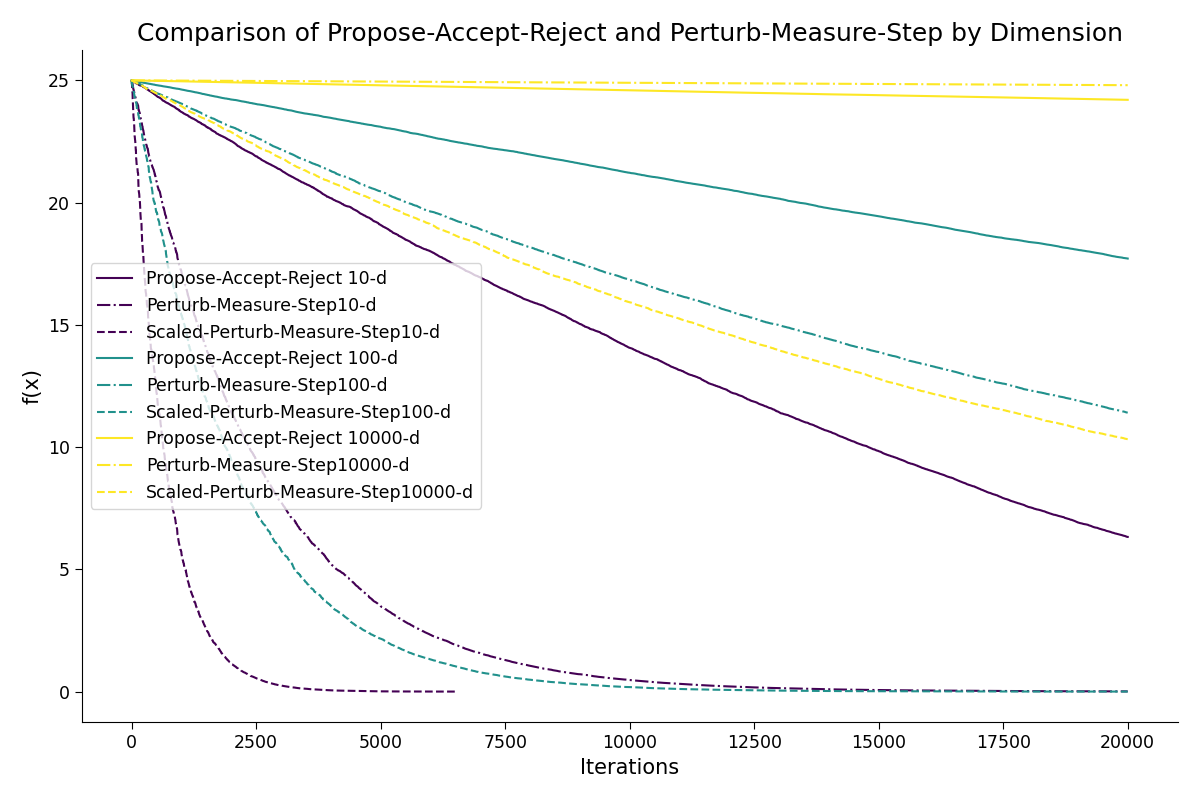

In [5]:
def simple_quadratic(x):
  return np.sum(x**2)

def scale_stable_propose(x, step_size=0.1, rng=np.random.default_rng()):
  dim = x.shape[0]
  step_scale = step_size / np.sqrt(dim)
  proposed_x = x + rng.standard_normal(size=x.shape) * step_scale
  return proposed_x

# Propose-accept-reject loop
def propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(0)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_proposed = 1
    while z > step_size**2 and len(z_history) < max_proposals:
      proposed_x = scale_stable_propose(x, step_size=step_size, rng=par_rng)
      z_proposed = simple_quadratic(proposed_x)
      if z_proposed < z:
        x = proposed_x
        z = z_proposed
      z_history.append(z)
    histories.append(z_history)
  return histories

# Perturb-measure-step
def perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    num_steps = 0
    while z_history[-1] > step_size:
      for dim in range(N):
        x[dim] += test_perturb #perturb
        z_test = simple_quadratic(x) #test
        x[dim] -= test_perturb # un-perturb
        dim_grad_est = (z_test - z) / test_perturb #measure slope
        x[dim] -= step_scale * dim_grad_est #step
        num_steps += 1
        z = simple_quadratic(x)
        #num_function_evaluations += 2
        x_history.append(x)
        z_history.append(z)
        if num_steps > max_steps:
          break
      if num_steps > max_steps:
        break
    histories.append(z_history)
  return histories

def good_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def scaling_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    dimensional_scale_factor = np.sqrt(np.pi * N / 2)
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

def over_scaling_perturb_measure_step(N_Dim, step_scale, max_steps, perturbation_scale, starting_distance_from_optimal, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  histories = []
  for N in N_Dim:
    x = rng.standard_normal(size=N)
    x = x / np.linalg.norm(x) * starting_distance_from_optimal
    z = simple_quadratic(x)
    z_history = [z]
    dimensional_scale_factor = N # np.sqrt(np.pi * N / 2)
    while z > step_scale and len(z_history) < max_steps:
      raw_test_perturb = rng.standard_normal(size=N)
      unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb)
      test_perturbation = unit_test_perturb * perturbation_scale
      z_test = simple_quadratic(x + test_perturbation)
      directional_grad_est = (z_test - z) / perturbation_scale
      x -= step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb
      z = simple_quadratic(x)
      z_history.append(z)
    histories.append(z_history)
  return histories

# Parameters
test_rng = np.random.default_rng(0)
N_Dim = [10, 100, 10000]
step_size = 0.001
max_proposals = 20000
max_steps = 20000
starting_distance_from_optimal = 5
test_perturb = 0.00001
step_scale = 0.001

# Collect data
z_par_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
#z_pms_histories = perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_gpms_histories = good_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
z_spms_histories = scaling_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)
#z_ospms_histories = over_scaling_perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis  # This colormap goes from light (yellow) to dark (blue)
colors = cmap(np.linspace(0, 1, len(N_Dim)))

for ii, N in enumerate(N_Dim):
  evals_per_step = N + 1
  z_par_vals = z_par_histories[ii]
  #z_pms_vals = z_pms_histories[ii]
  z_gpms_vals = z_gpms_histories[ii]
  z_spms_vals = z_spms_histories[ii]
  #z_ospms_vals = z_ospms_histories[ii]
  # always just 2 evaluations per step for the chaotic-good perturb-measure-step
  ax.plot(z_par_vals, color=colors[ii], linestyle='-', label=f'Propose-Accept-Reject {N_Dim[ii]}-d')
  #ax.plot(z_pms_vals, color=colors[ii], linestyle='-.', label=f'Systematic-Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(z_gpms_vals, color=colors[ii], linestyle='-.', label=f'Perturb-Measure-Step{N_Dim[ii]}-d')
  ax.plot(z_spms_vals, color=colors[ii], linestyle='--', label=f'Scaled-Perturb-Measure-Step{N_Dim[ii]}-d')
#  ax.plot(z_ospms_vals, color=colors[ii], linestyle='-', label=f'Over-Scaling-Perturb-Measure-Step{N_Dim[ii]}-d')

ax.set_xlabel('Iterations')
ax.set_ylabel('f(x)')
ax.set_title('Comparison of Propose-Accept-Reject and Perturb-Measure-Step by Dimension')
ax.legend()

plt.show()

In accordance with our analysis above, for lower dimensions perturb-measure-step does better because the squared gradient term compensates for the $\frac{1}{n}$ drop off, but eventually as we go up to 10,000 dimensions in the figure above, propose-accept-reject becomes more efficient. At what scale one method become better than the other will of course depend on the details of the problem, but as might be expected, because perturb-measure-step uses estimates of the slope to inform its steps it is at an advantage when there are steep gradients to be informed by. The point though isn't really about which of perturb-measure-step or propose-accept-reject is better in higher dimensions, the point is they are both become ineffective as we move into higher-dimensional optimization problems.

On the face of it, it might seem like propose-accept-reject scales better to higher dimensions than does perturb-measure-step, and indeed in this simplified analysis it does. However, in practice, step sizes and step scaling factors are critical to the rate of convergence. Higher values allow for rapid traversal of the parameter space, while smaller steps allow for greater percision in dialing the the exact loccation of the optima once the rough neighbourhood in parameter space has been reached. Because the perturb-measure-step algorithm takes steps in proportion to the gradient, and (for analytic functions) the gradient gets close to zero near optima, it is possible to have a higher step-size scaling in perturb-measure-step than average step-sizes in propose-accept-reject.

In the version of perturb measure step above, we always take a step proportional to the rate of improvement in the sampled test direction. Now this rate of improvement is the product of two components, one is the magnitude of the gradient, $\| \mathbf{g} \|$ at the point $\mathbf{x}$, and the other is the alignment of the test direction with the gradient direction, this is given by $\frac{\xi_1}{\| \xi \|}$. Now for large $n$ the average value of $\frac{\xi_1}{\| \xi \|}$, is roughly $\sqrt{\frac{2}{n \pi}}$, which means that we can safely scale up our step sizes by the inverse of this amount, to (partially) compensate for the increasing lack of alignment with gradient in higher dimensions. This leads to the scaled-perturb-measure-step in the plot above, which clearly outperforms the unscaled-perturb-measure-step and propose-accept-reject, with its expected improvement per step of

$$ s\|\mathbf{g}\|^2 \sqrt{\frac{\pi}{2n}}$$

So looks like we can't really have scaling any better than $\frac{1}{\sqrt{n}}$ with either propose-accept-reject or perturb-measure-step. If it takes $5$ iterations to solve a problem in one dimension it will take $50 = 5 \cdot \sqrt{100}$ iterations to solve the $n=100$ dimension equivalent of the problem, $500 = 5 \cdot \sqrt{10000}$ to solve the $n=10000$ dimension equivalent of the problem, and so on.


### Propose-Accept-Reject Method

The **propose-accept-reject** method is a stochastic optimization technique that iteratively proposes changes to a parameter vector and accepts these changes based on a simple comparison rule. Here's how this method operates in detail:

1. **Initialization**:
   - Initialize the parameter vector $\mathbf{x} \in \mathbb{R}^n$.
   - Choose a step size $s$ for the perturbations.

2. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$ to establish a baseline for comparison.

   2. **Generate a Candidate Point**:
      - Sample a candidate point $\mathbf{x}' = \mathbf{x} + \frac{s}{\sqrt{n}} \cdot \mathcal{N}(0, \mathbf{I})$, where $\mathcal{N}(0, \mathbf{I})$ represents a standard, $n$-dimensional multivariate normal distribution. This perturbation adjusts the scale of the step size inversely with the square root of the dimensionality, keeping average step size roughly constant regardless of the number of dimensions.

   3. **Candidate Point Evaluation**:
      - Evaluate the function at the candidate point $f(\mathbf{x}')$.

   4. **Accept or Reject the Candidate**:
      - Compare the function values: if $f(\mathbf{x}') < f(\mathbf{x})$, then update $\mathbf{x} \leftarrow \mathbf{x}'$. This step implements the 'accept if better' rule, where only improvements lead to an update. (If we were minimizing we would use $f(\mathbf{x}') > f(\mathbf{x})$ as our acceptance criteria instead.)

   5. **Convergence Check**:
      - Repeat the loop until a convergence criterion is met. Criteria can include a maximum number of function evaluations, a maximum number of consecutive failed attempts at improvement, achievement of a target function value, or a combination of these factors.


### Sequential Perturb-Measure-Step Method

Sequential perturb-measure-step grew out of the idea of using more information from function evaluations. In one dimensional problems there was only on direction to make a perturbation. In two dimensions we alternated our test perturbations between the two dimensions sequentially.

A. **Initialization**:
   - Initialize the parameter vector $\mathbf{x} \in \mathbb{R}^n$.
   - Choose a test perturbation magnitude $s_{\text{test}}$ and a parameter step scaling size $s_x$.

B. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$ to establish a baseline.
   2. **Perturb Each Dimension Separately**:
      - For each dimension $i \in \{1, 2, \dots, n\}$:
        1. Generate a test point $\mathbf{x}' = \mathbf{x} + \mathbf{e}^i \cdot s_{\text{test}}$. Here, $\mathbf{e}^i$ is the standard orthonormal unit basis vector for the $i^{\text{th}}$ dimension.
        2. Evaluate the function at $\mathbf{x}'$.
        3. Estimate the rate of change in the $i^{\text{th}}$ dimension: $$ \hat{g}_i = \frac{f(\mathbf{x}') - f(\mathbf{x})}{s_{\text{test}}} $$
        4. Update $\mathbf{x} \leftarrow \mathbf{x} + \mathbf{e}^i \cdot \hat{g}_i \cdot s_x$.
        5. $s_{\text{test}}$
   3. **Convergence Check**:
      - Repeat the loop until a convergence criterion is met, such as a maximum number of function evaluations, a significant drop in improvement per iteration, achievement of a target function value, or a combination of these factors.

### Batch Perturb-Measure-Step Method

An alternative approach to the sequential perturb-measure-step method is to estimate changes in all dimensions before applying a single comprehensive update. This method can be more stable as it considers the cumulative gradient vector from all dimensions before making adjustments.

1. **Initialization**:
   - Similar to the sequential method.

2. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$.
   2. **Perturb and Measure in Batch**:
      - For each dimension $i \in \{1, 2, \dots, n\}$:
        1. Generate a test point $\mathbf{x}_{\text{test}} = \mathbf{x} + \mathbf{e}^i \cdot s$        
        2. Evaluate $f(\mathbf{x}_{\text{test}})$.
        3. Estimate the rate of change in the $i^{\text{th}}$ dimension: $$ \hat{g}_i = \frac{f(\mathbf{x}_{\text{test}}) - f(\mathbf{x})}{s_{\text{test}}} $$
   3. **Update Using the Complete Gradient Vector**:
      - Construct the gradient vector $\hat{\mathbf{g}} = (\hat{g}_1, \hat{g}_2, \dots, \hat{g}_n)$.
      - Update $\mathbf{x} \leftarrow \mathbf{x} + \hat{\mathbf{g}} \cdot s_x$.
   4. **Convergence Check**:
      - Similar to the sequential method.

The sequential and batch flavours of perturb-measure-step are roughly equivalent, though the batch version my help avoid some pathological cases that emerge for the sequential variant.

### Reckless-Perturb-Measure-Step Method

The perturb-measure-step variants described above, here after the **careful-perturb-measure-step** methods, are overly meticulous, evaluating each dimension separately and systematically. There is a better way which embraces chaotic power inherent in the **propose-accept-reject** method, while still extracting significant information from each function evaluation by measuring the rate of change. A we call the hybrid approach that achieves this **reckless-perturb-measure-step**.

The core idea is to randomly select a direction for testing the function's response, then based on the estimated rate of improvement in that direction within the parameter space, take a proportional step. Here's the process in detail:

1. **Initialization**:
   - Initialize the parameter vector $\mathbf{x} \in \mathbb{R}^n$.
   - Choose a test perturbation magnitude $s_{\text{test}}$ and a parameter step scaling size $s_x$.

2. **Loop Through the Following Steps**:
   1. **Function Evaluation**:
      - Evaluate $f(\mathbf{x})$.

   2. **Generate a Random Direction**:
      - Generate a raw random vector $\mathbf{v}$ from a standard, $n$-dimensional multivariate normal distribution $\mathcal{N}(0, \mathbf{I})$. This point sits in a 'Gaussian Cloud' around the orgin.
      - Normalize $\mathbf{v}$ to obtain a random unit vector $\mathbf{u} = \frac{\mathbf{v}}{\|\mathbf{v}\|}$. This point sits on the surface of a hyper-sphere of radius 1.

   3. **Test Point Evaluation**:
      - Generate a test point $\mathbf{x}' = \mathbf{x} + s_{\text{test}} \cdot \mathbf{u}$.
      - Evaluate the function at the test point $f(\mathbf{x}')$.

   4. **Measure Rate of Change**:
      - Calculate the rate of change of $f$ in the direction of $\mathbf{u}$ using the formula:
        $$\Delta f_{\mathbf{u}} = \frac{f(\mathbf{x}') - f(\mathbf{x})}{s_{\text{test}}}$$
        Because $\mathbf{u}$ is a unit vector, $s_{\text{test}}$ gives the 'run' in this 'rise over run' slope calculation.

   5. **Update Parameter Vector**:
      - Update $\mathbf{x}$ by moving in the direction of $\mathbf{u}$, scaled by the estimated rate of improvement and the step scaling size:
        $$\mathbf{x} \leftarrow \mathbf{x} + s_x \cdot \Delta f_{\mathbf{u}} \cdot \mathbf{u}$$

   6. **Convergence Check**:
      - Repeat the loop until a convergence criterion is met, such as a maximum number of function evaluations, a significant drop in improvement per iteration, achievement of a target function value, some combination of these factors, or even something else.

In [6]:
def simple_quadratic(x):
  return np.sum(x * x, axis=0)

def gradient_simple_quadratic(x):
  return 2 * x

test_rng = np.random.default_rng(42)

def propose_accept_reject_average_improvement(x, step_size, num_samples=400, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  N = x.shape[0]
  stable_step_scale = step_size / np.sqrt(N)
  proposals = x[..., np.newaxis] + stable_step_scale * rng.standard_normal(size=(N, num_samples,))
  f_x = simple_quadratic(x)
  f_proposals = simple_quadratic(proposals)
  f_diff = f_proposals - f_x
  f_diff[f_diff < 0] = 0
  empirical_improvement = np.mean(f_diff)
  g_x = gradient_simple_quadratic(x)
  theoretical_improvement = np.linalg.norm(g_x) * stable_step_scale * np.sqrt(2/np.pi) * 0.5
  best_possible_improvement = np.linalg.norm(g_x) * step_size
  return empirical_improvement, theoretical_improvement, best_possible_improvement

propose_accept_reject_average_improvement(10 * test_rng.standard_normal(size=500), 0.0000001)

(7.978511166584212e-07, 7.652219865725167e-07, 4.2890625133335306e-05)

In [7]:
def systematic_perturb_measure_step_average_improvement(x, test_scale, step_scale, num_samples=400, rng=None):
  if rng is None:
    rng = np.random.default_rng(42)
  N = x.shape[0]
  perturbs = test_scale * np.eye(N)
  test_points = x[..., np.newaxis] + perturbs
  f_x = simple_quadratic(x)
  f_test_points = simple_quadratic(test_points)
  f_diffs = f_test_points - f_x
  f_steps = f_diffs / test_scale * step_scale
  new_xs = x[..., np.newaxis] + np.diag(f_steps) # N x N
  f_new_xs = simple_quadratic(new_xs)
  empirical_improvement = np.mean(f_new_xs - f_x)
  g_x = gradient_simple_quadratic(x)
  theoretical_improvement = (np.linalg.norm(g_x))**2 * step_scale * (1/N)
  best_possible_improvement = (np.linalg.norm(g_x))**2 * step_scale
  return empirical_improvement, theoretical_improvement, best_possible_improvement

systematic_perturb_measure_step_average_improvement(10 * test_rng.standard_normal(size=500), 0.0000001, 0.0001)

(0.04148454670119099, 0.04148041493581571, 20.740207467907855)

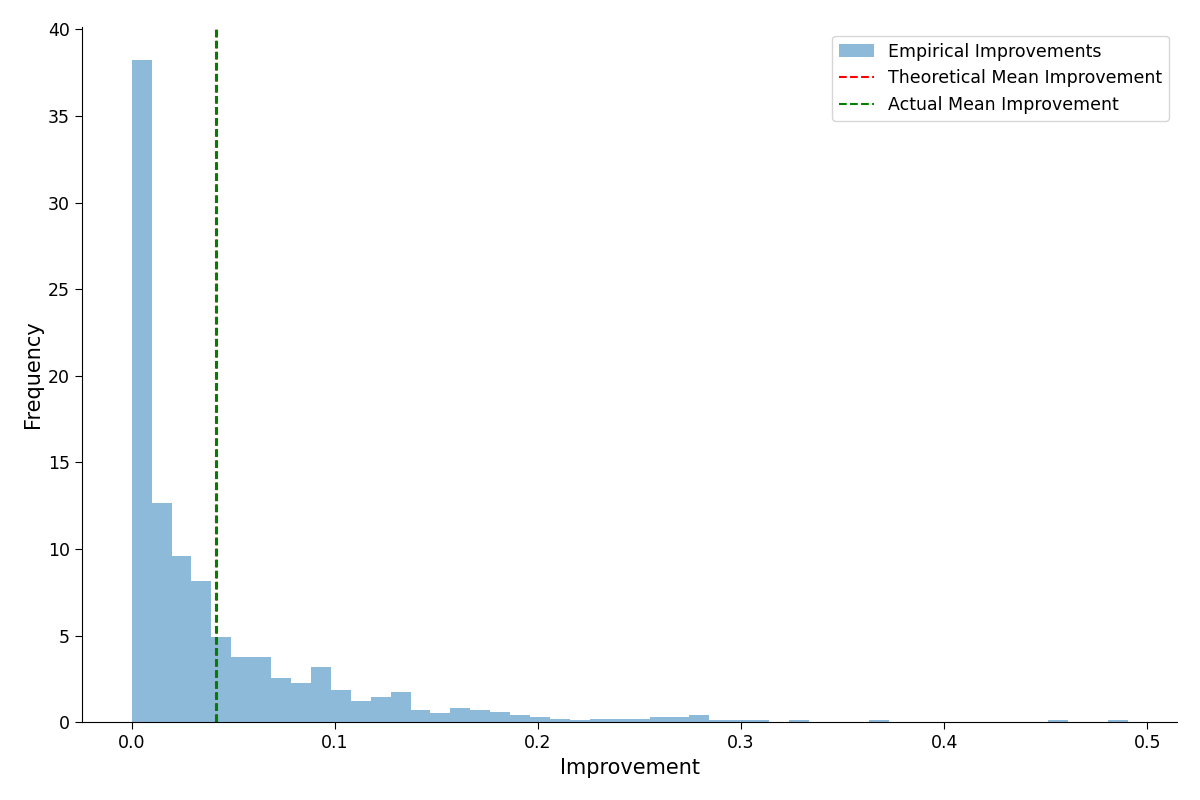

(0.0422001218158257, 0.041639701700969325, 20.819850850484663)

In [8]:
def measure_step_improvement(initial_point, test_step_size, step_scale, num_samples=400, rng=None, plot=False):
  """
  Measure the average empirical improvement of a perturbation-based optimization method.
  Parameters:
  - initial_point (np.ndarray): Starting point in parameter space.
  - test_step_size (float): Magnitude of the perturbations applied.
  - step_scale (float): Scaling factor for step size based on the optimization feedback.
  - num_samples (int, optional): Number of perturbation samples.
  - rng (np.random.Generator, optional): Random number generator for reproducibility.
  - plot (bool, optional): If True, plot the histogram of empirical improvements.
  Returns:
  - tuple: Average empirical improvement, theoretical improvement, best possible improvement.
  """
  if rng is None:
    rng = np.random.default_rng()
  N = initial_point.shape[0]
  raw_perturbs = rng.standard_normal(size=(N, num_samples))
  unit_perturbs = raw_perturbs / np.linalg.norm(raw_perturbs, axis=0, keepdims=True)
  test_points = initial_point[:, np.newaxis] + test_step_size * unit_perturbs
  value_at_initial = simple_quadratic(initial_point)
  values_at_test_points = simple_quadratic(test_points)
  diffs = values_at_test_points - value_at_initial
  steps = diffs / test_step_size * step_scale
  new_points = initial_point[:, np.newaxis] + steps[np.newaxis, :] * unit_perturbs
  values_at_new_points = simple_quadratic(new_points)
  improvements = values_at_new_points - value_at_initial
  average_improvement = np.mean(improvements)
  gradient_at_initial = gradient_simple_quadratic(initial_point)
  theoretical_improvement = (np.linalg.norm(gradient_at_initial))**2 * step_scale * (1/N)
  best_possible_improvement = (np.linalg.norm(gradient_at_initial))**2 * step_scale
  if plot:
      plot_improvements(improvements, average_improvement, theoretical_improvement)
  return average_improvement, theoretical_improvement, best_possible_improvement

def plot_improvements(improvements, average_improvement, theoretical_improvement):
  fig, ax = plt.subplots(figsize=(12, 8))
  remove_ip_clutter(fig)
  n, bins, patches = ax.hist(improvements, bins=50, density=True, alpha=0.5, label='Empirical Improvements')
  ax.axvline(theoretical_improvement, label='Theoretical Mean Improvement', color='r', linestyle='--')
  ax.axvline(average_improvement, label='Actual Mean Improvement', color='g', linestyle='--')
  ax.set_xlabel('Improvement')
  ax.set_ylabel('Frequency')
  ax.legend()
  plt.show()

measure_step_improvement(10 * test_rng.standard_normal(size=500), 0.0000001, 0.0001, num_samples=1000, plot=True)

(500, 10000)


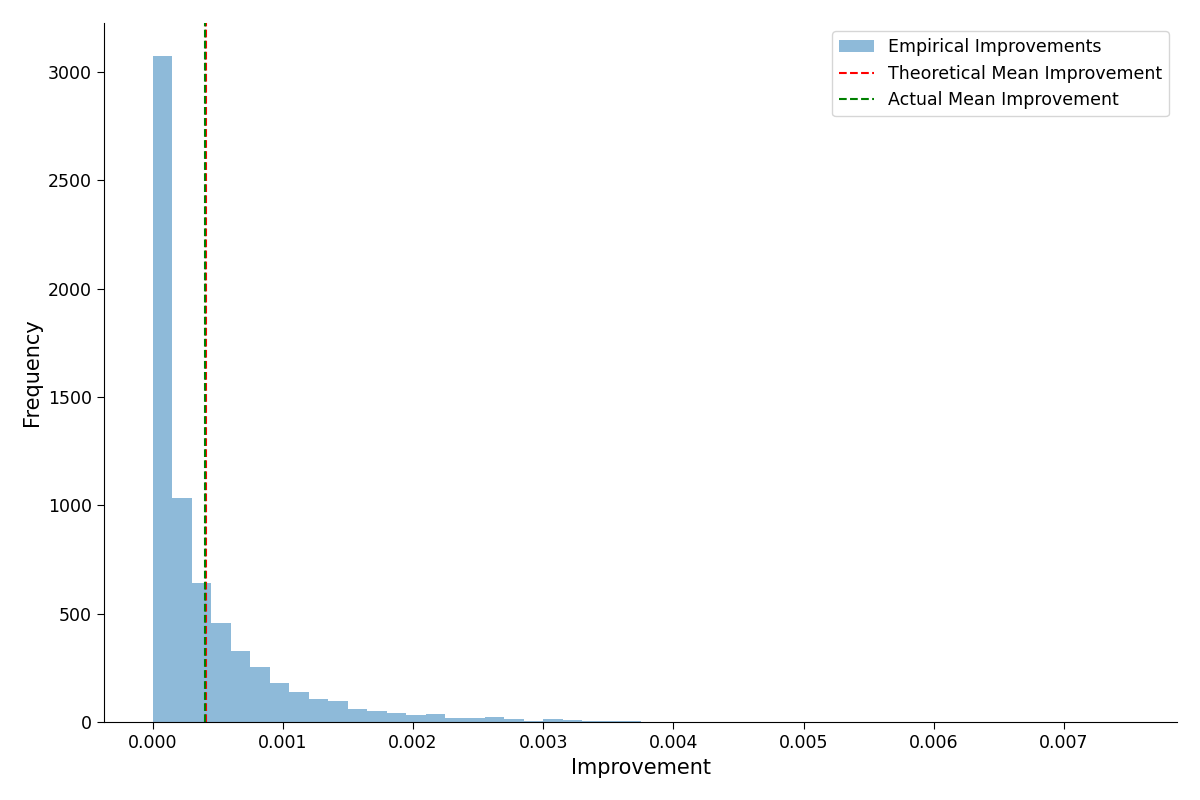

(0.00040121183870287495, 0.0004115132918144228, 0.2057566459072114)

In [9]:
import scipy.stats
def reckless_perturb_measure_step_average_improvement(x, test_step_size, step_scale, num_samples=400, rng=None, plot=False):
  if rng is None:
    rng = np.random.default_rng(42)
  N = x.shape[0]
  raw_perturbs = rng.standard_normal(size=(N, num_samples))
  unit_perturbs = raw_perturbs / np.linalg.norm(raw_perturbs, axis=0, keepdims=True)
  test_points = x[:, np.newaxis] + test_step_size * unit_perturbs
  f_x = simple_quadratic(x)
  f_test_points = simple_quadratic(test_points)
  f_diffs = f_test_points - f_x
  f_steps = f_diffs / test_step_size * step_scale
  new_xs = x[:, np.newaxis] + f_steps[np.newaxis,:] * unit_perturbs
  print(new_xs.shape)
  f_new_xs = simple_quadratic(new_xs)
  empirical_improvements = f_new_xs - f_x
  average_empirical_improvement = np.mean(empirical_improvements)
  g_x = gradient_simple_quadratic(x)
  theoretical_improvement = (np.linalg.norm(g_x))**2 * step_scale * (1/N)
  best_possible_improvement = (np.linalg.norm(g_x))**2 * step_scale
  if plot:
    fig, ax = plt.subplots(figsize=(12, 8))
    remove_ip_clutter(fig)
    ax.hist(empirical_improvements, bins=50, density=True, alpha=0.5, label='Empirical Improvements')
    ax.axvline(theoretical_improvement, label='Theoretical Mean Improvement', color='r', linestyle='--')
    ax.axvline(average_empirical_improvement, label='Actual Mean Improvement', color='g', linestyle='--')
    ax.set_xlabel('Improvement')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()
  return average_empirical_improvement, theoretical_improvement, best_possible_improvement

reckless_perturb_measure_step_average_improvement(10 * test_rng.standard_normal(size=500), 0.00000001, 0.000001, num_samples=10000, plot=True)

Another way of coneceptualizing this is as the projection of the gradient of $f$ onto the random direction  $$ \hat{\mathbf{g} \cdot \mathbf{u}} $$

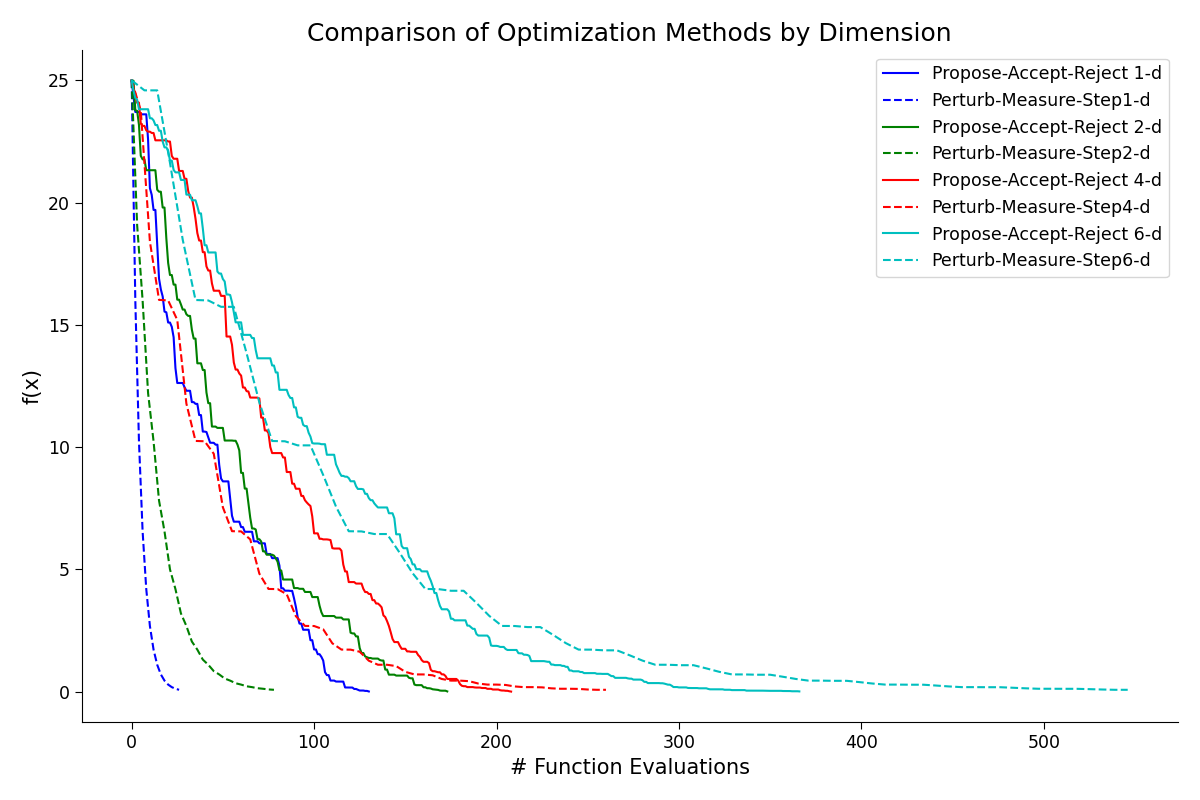

In [10]:
# Parameters
N_Dim = [1, 2, 4, 6]
step_size = 0.1
max_proposals = 1500
max_steps = 200
starting_distance_from_optimal = 5
test_perturb = 0.00001
step_scale = 0.1

# Collect data
z_par_histories = propose_accept_reject(N_Dim, step_size, max_proposals, starting_distance_from_optimal)
z_pms_histories = perturb_measure_step(N_Dim, step_scale, max_steps, test_perturb, starting_distance_from_optimal)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c']  # colors for different dimensions

for ii, N in enumerate(N_Dim):
  evals_per_step = N + 1
  z_par_vals = z_par_histories[ii]
  z_pms_vals = z_pms_histories[ii]
  n_evaluations = np.arange(0, evals_per_step * (len(z_pms_vals)), evals_per_step)
  ax.plot(np.arange(len(z_par_vals)), z_par_vals, f'{colors[ii]}-', label=f'Propose-Accept-Reject {N_Dim[ii]}-d')
  ax.plot(n_evaluations, z_pms_vals, f'{colors[ii]}--', label=f'Perturb-Measure-Step{N_Dim[ii]}-d')

ax.set_xlabel('# Function Evaluations')
ax.set_ylabel('f(x)')
ax.set_title('Comparison of Optimization Methods by Dimension')
ax.legend()

plt.show()

In [11]:
def plot_samples(N_dimensions, step_size):
  stable_samples = [scale_stable_propose(np.zeros(N_dimensions, dtype=float), step_size) for _ in range(10000)]
  fixed_scale_samples = [fixed_scale_propose(np.zeros(N_dimensions, dtype=float), step_size) for _ in range(10000)]

  norm_stable_samples = [np.sqrt(np.sum(s_**2)) for s_ in stable_samples]
  norm_fixed_scale_samples = [np.sqrt(np.sum(s_**2)) for s_ in fixed_scale_samples]

  plt.figure(figsize=(6, 4))
  plt.hist(norm_stable_samples, bins=100, alpha=0.5, label='Scale-Stable')
  plt.hist(norm_fixed_scale_samples, bins=100, alpha=0.5, label='Fixed-Scale')
  plt.legend()
  plt.show()
# Create interactive widgets
interactive_plot = widgets.interactive(plot_samples, N_dimensions=(1, 50), step_size=(0.01, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '250px' # Adjust the plot height
interactive_plot

interactive(children=(IntSlider(value=25, description='N_dimensions', max=50, min=1), FloatSlider(value=0.5, d…